In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torchvision import transforms
from torchvision import models
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from PIL import Image
%matplotlib inline

In [ ]:
dataset = CIFAR10(root='data/', download=True, transform=ToTensor())
test_dataset = CIFAR10(root='data/', train=False, transform=ToTensor())

Files already downloaded and verified


In [ ]:
classes = dataset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
class_count = {}
for _, index in dataset:
    label = classes[index]
    if label not in class_count:
        class_count[label] = 0
    class_count[label] += 1
class_count

{'airplane': 5000,
 'automobile': 5000,
 'bird': 5000,
 'cat': 5000,
 'deer': 5000,
 'dog': 5000,
 'frog': 5000,
 'horse': 5000,
 'ship': 5000,
 'truck': 5000}

In [ ]:
torch.manual_seed(43)
val_size = 5000
train_size = len(dataset) - val_size
train_size

45000

In [ ]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [ ]:
batch_size=128

In [ ]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape: torch.Size([128, 3, 32, 32])


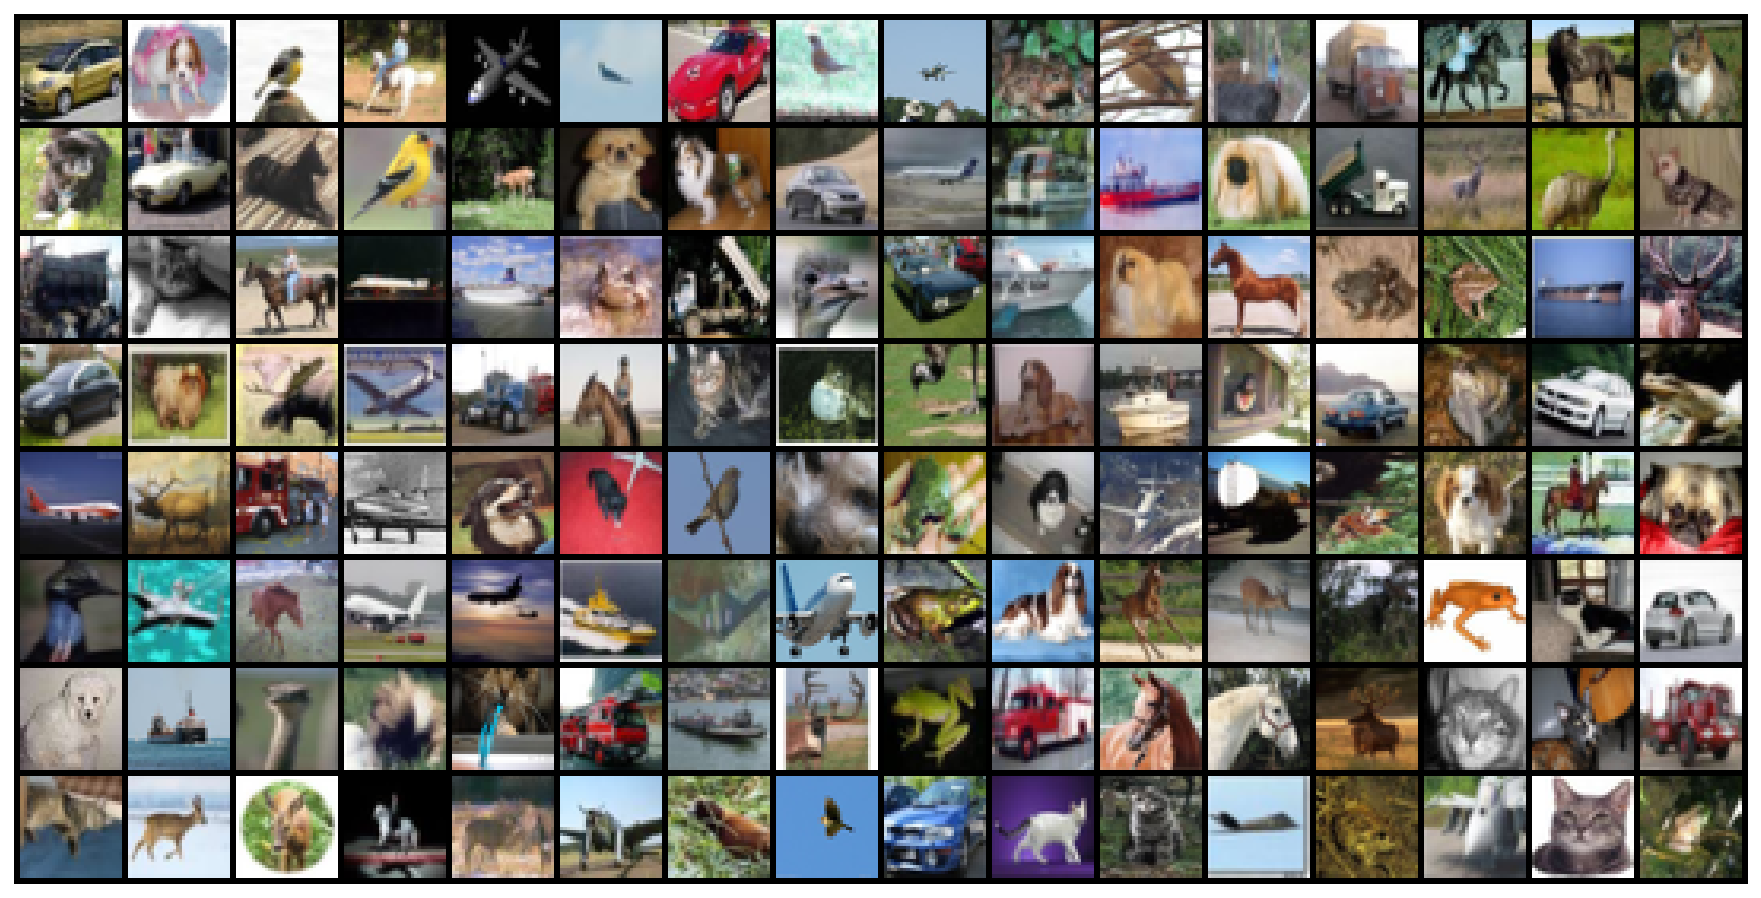

In [ ]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [ ]:
torch.cuda.is_available()




True

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [ ]:
input_size = 3*32*32
output_size = 10

In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.drop_out = nn.Dropout()

        self.fc1 = nn.Linear(8 * 8 * 64, 1000)
        self.fc2 = nn.Linear(1000, output_size)
       
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = F.log_softmax(self.fc2(out), dim=1)
        return out

In [ ]:
model = Classifier()
model.to(device)

Classifier(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=4096, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=10, bias=True)
)

In [ ]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 100
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images, labels in val_loader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
        
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(val_loader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(val_loader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(val_loader)))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 1/100..  Training Loss: 1.754..  Test Loss: 1.549..  Test Accuracy: 0.433
Epoch: 2/100..  Training Loss: 1.544..  Test Loss: 1.411..  Test Accuracy: 0.496
Epoch: 3/100..  Training Loss: 1.481..  Test Loss: 1.376..  Test Accuracy: 0.505
Epoch: 4/100..  Training Loss: 1.421..  Test Loss: 1.335..  Test Accuracy: 0.517
Epoch: 5/100..  Training Loss: 1.392..  Test Loss: 1.309..  Test Accuracy: 0.529
Epoch: 6/100..  Training Loss: 1.381..  Test Loss: 1.333..  Test Accuracy: 0.531
Epoch: 7/100..  Training Loss: 1.348..  Test Loss: 1.233..  Test Accuracy: 0.564
Epoch: 8/100..  Training Loss: 1.326..  Test Loss: 1.201..  Test Accuracy: 0.576
Epoch: 9/100..  Training Loss: 1.305..  Test Loss: 1.213..  Test Accuracy: 0.568
Epoch: 10/100..  Training Loss: 1.281..  Test Loss: 1.190..  Test Accuracy: 0.574
Epoch: 11/100..  Training Loss: 1.285..  Test Loss: 1.167..  Test Accuracy: 0.586
Epoch: 12/100..  Training Loss: 1.265..  Test Loss: 1.168..  Test Accuracy: 0.588
Epoch: 13/100..  Training

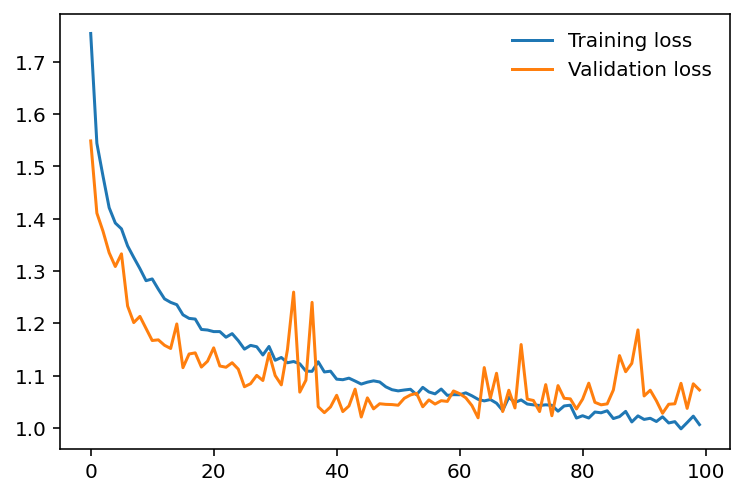

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [ ]:
def check_accuracy_on_test(testloader,device='gpu'):    
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy of the network on test images: %d %%' % (100 * correct / total))
    return correct / total

check_accuracy_on_test(test_loader,'cuda')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Accuracy of the network on test images: 58 %


0.5827

In [ ]:
torch.save(model.state_dict(), 'checkpoint.pth')

##Transfert learning.

In [ ]:
modified_transf = transforms.Compose([
                              transforms.Resize(255),
                              transforms.CenterCrop(224),
                              transforms.ToTensor(),
                              transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                             ])

In [ ]:
dataset = CIFAR10(root='data/', download=True, transform=modified_transf)
test_dataset = CIFAR10(root='data/', train=False, transform=modified_transf)

Files already downloaded and verified


In [ ]:
torch.manual_seed(43)
val_size = 5000
train_size = len(dataset) - val_size
train_size

45000

In [ ]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [ ]:
batch_size=128

In [ ]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [ ]:
model = models.vgg19(pretrained=True)
print(model)

for parameter in model.parameters():
    parameter.requires_grad = False


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 4096)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(4096, 10)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
print(model)

def train_model(model, trainloader, validloader, epochs, print_every, criterion, optimizer, device='cpu'):
    epochs = epochs
    print_every = print_every
    steps = 0

    model.to(device)

    for i in range(epochs):
        print("Epoch: {}".format(i+1))
        running_loss = 0
        for ii, (inputs, labels) in enumerate(trainloader):
            steps += 1

            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward and backward passes
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if steps % print_every == 0:
                valid_accuracy = check_validation_set(validloader,device)
                print("Epoch: {}|{}... ".format(i+1, epochs),
                      "Loss: {:.4f}".format(running_loss/print_every),
                      "Validation Accuracy: {}".format(round(valid_accuracy,4)))

                running_loss = 0
    print("TRAINING DONE!")
    
def check_validation_set(valid_loader,device='cpu'):    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in valid_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

train_model(model, train_loader, val_loader, 3, 40, criterion, optimizer, 'cuda')

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 1|3...  Loss: 1.6725 Validation Accuracy: 0.7932
Epoch: 1|3...  Loss: 0.4999 Validation Accuracy: 0.8176
Epoch: 1|3...  Loss: 0.4994 Validation Accuracy: 0.8226
Epoch: 1|3...  Loss: 0.4829 Validation Accuracy: 0.8396
Epoch: 1|3...  Loss: 0.4683 Validation Accuracy: 0.847
Epoch: 1|3...  Loss: 0.4365 Validation Accuracy: 0.8472
Epoch: 1|3...  Loss: 0.4526 Validation Accuracy: 0.8468
Epoch: 1|3...  Loss: 0.3825 Validation Accuracy: 0.8604
Epoch: 2
Epoch: 2|3...  Loss: 0.0352 Validation Accuracy: 0.8652
Epoch: 2|3...  Loss: 0.1647 Validation Accuracy: 0.8644
Epoch: 2|3...  Loss: 0.1598 Validation Accuracy: 0.8686
Epoch: 2|3...  Loss: 0.1608 Validation Accuracy: 0.8584
Epoch: 2|3...  Loss: 0.1878 Validation Accuracy: 0.8632
Epoch: 2|3...  Loss: 0.1838 Validation Accuracy: 0.8614
Epoch: 2|3...  Loss: 0.2152 Validation Accuracy: 0.8616
Epoch: 2|3...  Loss: 0.1991 Validation Accuracy: 0.8598
Epoch: 2|3...  Loss: 0.2030 Validation Accuracy: 0.8618
Epoch: 3
Epoch: 3|3...  Loss: 0.0309 Val

In [ ]:
def check_accuracy_on_test(testloader,device='gpu'):    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
    return correct / total

check_accuracy_on_test(test_loader,'cuda')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Accuracy of the network on the 10000 test images: 86 %


0.8645

In [ ]:
model.class_to_idx = dataset.class_to_idx

checkpoint = {'transfer_model': 'vgg19',
              'input_size': 25088,
              'output_size': 10,
              'features': model.features,
              'classifier': model.classifier,
              'optimizer': optimizer.state_dict(),
              'state_dict': model.state_dict(),
              'idx_to_class': {v: k for k, v in dataset.class_to_idx.items()}
             }

torch.save(checkpoint, 'check.pth')

In [5]:
from collections import OrderedDict
def load_checkpoint(filepath):
    model_info = torch.load(filepath)
    model = models.vgg19(pretrained=True)
    classifier = nn.Sequential(OrderedDict([
                              ('fc1', nn.Linear(25088, 4096)),
                              ('relu', nn.ReLU()),
                              ('fc2', nn.Linear(4096, 10)),
                              ('output', nn.LogSoftmax(dim=1))
                              ]))

    model.classifier = classifier
    model.load_state_dict(model_info['state_dict'])
    return model, model_info

model, model_info = load_checkpoint('/content/drive/Shareddrives/ML project/check.pth')
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [6]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    im = Image.open(image)
    width, height = im.size
    pic_coord = [width, height]
    max_span = max(pic_coord)
    max_element = pic_coord.index(max_span)
    if (max_element == 0):
        min_element = 1
    else:
        min_element = 0
    aspect_ratio=pic_coord[max_element]/pic_coord[min_element]
    new_pic_coord = [0,0]
    new_pic_coord[min_element] = 256
    new_pic_coord[max_element] = int(256 * aspect_ratio)
    
    im = im.resize(new_pic_coord)   
    
    width, height = new_pic_coord
    left = (width - 244)/2
    top = (height - 244)/2
    right = (width + 244)/2
    bottom = (height + 244)/2
    
    im = im.crop((left, top, right, bottom))
    
    np_image = np.array(im)
    
    np_image = np_image.astype('float64')
    np_image = np_image / [255,255,255]
    np_image = (np_image - [0.485, 0.456, 0.406])/ [0.229, 0.224, 0.225]
    np_image = np_image.transpose((2, 0, 1))
    
    return np_image

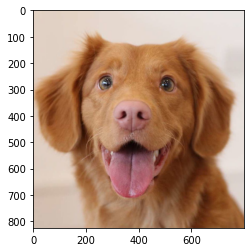

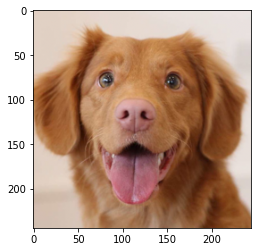

In [8]:
from os import listdir
im = Image.open('dog.jpg')
fig, ax = plt.subplots()
ax.imshow(im);

new_image = process_image('dog.jpg')

def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    image = image.transpose((1, 2, 0))
    
   
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    image = std * image + mean
    
    
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

imshow(new_image);

In [10]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    with torch.no_grad():
        image = process_image(image_path)
        image = torch.from_numpy(image)
        image.unsqueeze_(0)
        image = image.float()
        model, _ = load_checkpoint(model)
        outputs = model(image)
        probs, classes = torch.exp(outputs).topk(topk)
        return probs[0].tolist(), classes[0].add(1).tolist()
    
predict('dog.jpg','/content/drive/Shareddrives/ML project/check.pth')

([1.0,
  1.6305216213583357e-21,
  3.7524026997751274e-28,
  2.1076549161497823e-28,
  3.6907179321806993e-29],
 [6, 4, 3, 10, 8])

In [26]:
classes_ =  {"1":"aiplane",
            "2":"automobile",
            "3":"bird",
            "4":"cat",
            "5":"deer",
            "6":"dog",
            "7":"frog",
            "8":"horse",
            "9":"ship",
            "10":"truck"}

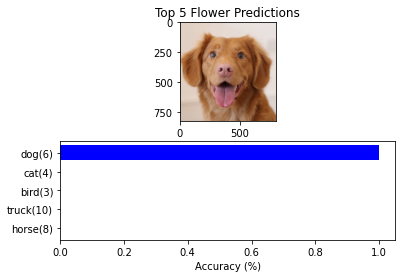

In [27]:
def display_prediction(image_path,model):
    probs, classes = predict(image_path,'/content/drive/Shareddrives/ML project/check.pth')
    plant_classes = [classes_[str(cls)] + "({})".format(str(cls)) for cls in classes]
    im = Image.open(image_path)
    fig, ax = plt.subplots(2,1)
    ax[0].imshow(im);
    y_positions = np.arange(len(plant_classes))
    ax[1].barh(y_positions,probs,color='blue')
    ax[1].set_yticks(y_positions)
    ax[1].set_yticklabels(plant_classes)
    ax[1].invert_yaxis() 
    ax[1].set_xlabel('Accuracy (%)')
    ax[0].set_title('Top 5 Flower Predictions')
    return None

display_prediction('dog.jpg','/content/drive/Shareddrives/ML project/check.pth')